# An Automated Method for the Estimate of Vertical Jump Power through Intertial Measurement Units

This repository has been created as supplementary material/code source for the proceeding entitled *An Automated Method for the Estimate of Vertical Jump Power through Intertial Measurement Units* published for the $39^{\rm{th}}$ Conference of the International Society of Biomechanics in Sports (ISBS 2021). 

The aim of the study was to correct for IMU inaccuracies when trying to estimate concentric peak and mean power generated by a jumper during a vertical jump. The idea was to devise multiple linear regression models (MLRs) embedding both anthropometric and time-frequency parameters. 

In this Python Notebook you can find a brief example of the procedure applied to achieve a better power estimate by exploiting the MLR. The example provided here will take into account a sample Countermovement Jump, hence the following two MLRs apply:


|-| Constant ($b_0$) | $P_C$ ($b_1$) | $\overline{P}_C$ ($b_2$) | $P_E$ ($b_3$) | $\overline{P}_E$ ($b_4$) | B ($b_5$) | T ($b_6$) | S ($b_7$) | I  ($b_8$)| $P_\Delta$ ($b_9$) |
|-| ---------------- | ------------- | -------------------------| ------------- | ------------------------ | --------- | --------- | --------- | --------- | ------------------ | 
| $MLR_{CMJ}^{P_C}$  |  10.40        | .47                      | .61           | -                        | -         |   -.24    | -         | -         | -.09               |    -     | 
| $MLR_{CMJ}^{\overline{P}_C}$   |  9.2      | .16              | .2            | .14                      | 1.33         |   -.1    | -.08    | -.11         | -               |    -8.91     | 


# Other resources
Notice that most of the signal processing have been already made. To check how acceleration traces were processed (i.e. aligned with the world reference frame), please take a look to the other GitHub repository I made for a similar problem: **<a href = "https://github.com/Maskul93/MLR_ISB2021"> Smartphone-Based Democratization of Jump Height Estimate</a>**.

In [1]:
## -- Load packages -- ##
import numpy as np                     # Array package
import pandas as pd                    # Data-Frame package
import math                            # "Basic Advanced" maths operations
import matplotlib.pyplot as plt        # Advanced plot tool
from scipy import integrate, signal    # Signal processing tool
import orient                          # Built-in orientation functions (from MLR_ISB2021 repo)

## -- Global variables -- ##
fs = 128                               # Sampling frequency for both systems
beta = .5                              # Complementary filter coefficient
g = 9.81                               # Gravitational acceleration [m/s^2]

Text(0, 0.5, 'Acceleration (m/s$^2$)')

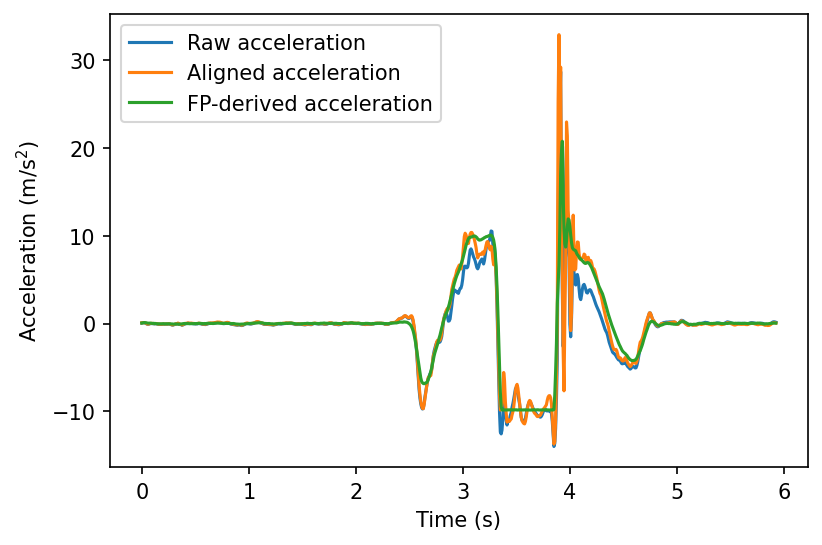

In [2]:
## -- Load the jump -- ##
x1 = pd.read_csv('./data/cmj_imu.csv')
x2 = pd.read_csv('./data/cmj_grf.csv')
grf = pd.DataFrame.to_numpy(x2[['grf']])    # Convert forceplate Ground Reaction Force into NumPy array
time = pd.DataFrame.to_numpy(x2[['time']])  # Convert time vector into NumPy array

## -- Convert accelerometer and gyroscope into NumPy arrays
acc_data = pd.DataFrame.to_numpy(x1[['ax','ay','az']])
gyr_data = pd.DataFrame.to_numpy(x1[['gx','gy','gz']])

r, p, y = orient.compl_filt(acc_data = acc_data, gyr_data = gyr_data, fs = fs, beta = beta)

q = orient.eul2quatern(r,p,y)    # Convert angles into a quaternion
a_glob = orient.align_to_WRF(q, acc_data)    # Align to WRF

## -- Get the acceleration (and the jumper mass) from GRF data
mass = np.mean(grf[0:99]) / g       # Compute mass from static phase
a_fp = ( grf / mass ) - g           # Get vertical acceleration

fig = plt.figure(1)
fig.dpi = 150
plt.plot(time, acc_data[:,1] - g)
plt.plot(time, a_glob)
plt.plot(time, a_fp)
plt.legend(['Raw acceleration', 'Aligned acceleration', 'FP-derived acceleration'])
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s$^2$)')

You got the following central frequencies:
 f1 = 7.28 [Hz]
 f2 = 4.39 [Hz]
 f3 = 0.6 [Hz]


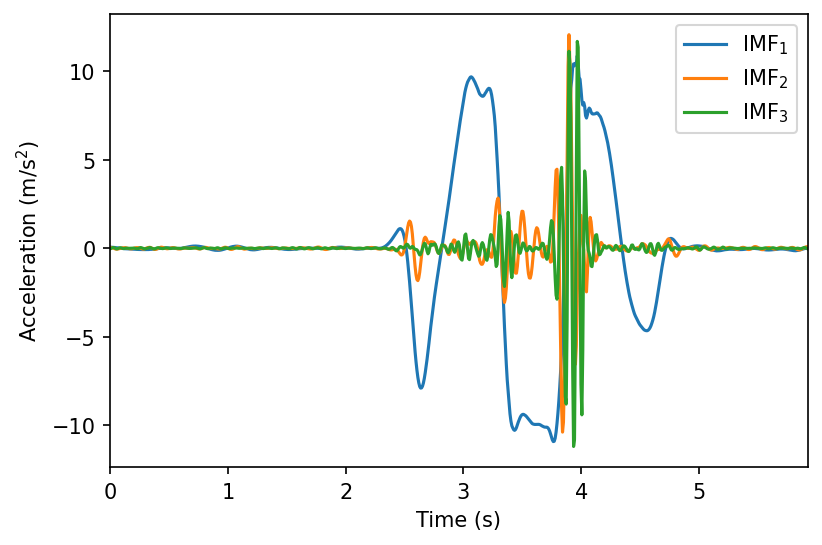

In [3]:
## --- Apply VMD --- ##
from vmdpy import VMD
## --- VMD Parameters --- ##
alpha = 100        # Mid Bandwidth Constrain  
tau = 0            # Noise-tolerance (no strict fidelity enforcement)  
K = 3              # 3 IMFs  
DC = 0             # DC part not imposed  
init = 0           # Initialize omegas uniformly  
tol = 1e-20        # Tolerance parameter

time = np.linspace(0, a_glob.shape[0]/fs, num = a_glob.shape[0])

## --- Run VMD on smartphone aligned acceleration trace --- ## 
u, u_hat, omega = VMD(a_glob, alpha, tau, K, DC, init, tol)  
IMFs = np.transpose(u)

fig = plt.figure(1)
fig.dpi = 150
plt.plot(time, IMFs)
plt.xlabel('Time (s)'), plt.ylabel('Acceleration (m/s$^2$)'), plt.xlim([time[0], time[-1]])
plt.legend(['IMF$_1$', 'IMF$_2$', 'IMF$_3$'])

f3, f2, f1 = omega[-1] * ( fs / 2 )    # Convert the central-frequencies to their "actual value"
print("You got the following central frequencies:\n f1 = " + str(round(f1, 2)) + " [Hz]\n f2 = " + str(round(f2, 2)) + 
     " [Hz]\n f3 = " + str(round(f3, 2)) + " [Hz]")

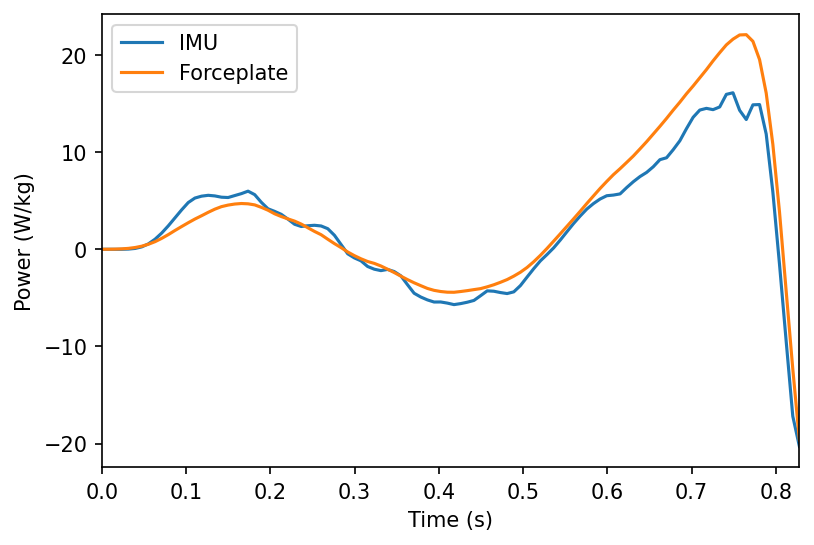

In [4]:
## -- Power computation -- ##
sb, to = 323, 429

def get_power(a, sb, to, fs):
    L = to - sb
    P = np.zeros(L)
    t = np.linspace(0, L/fs, num = L)
    v = integrate.cumtrapz(a[sb:to], t, initial=0)    # Perform the integration
    for k in range(0, L):
        P[k] = a[sb + k] * v[k]

    return np.array(P, dtype = np.float64)

def get_peaks(P, fs, hm):
    Pc = np.max(P)          # Peak Concentric Power value

    ## -- Search for changes in sign in power, i.e. isolate Concentric Power -- ##
    # Search forward
    for k in range(np.argmax(P), P.shape[0]):
        if P[k] < 0:
            tf_c = k
            break

    # Search backward
    for k in range(np.argmax(P), 0, -1):
        if P[k] < 0:
            ti_c = k
            break

    MPc = np.mean(P[ti_c : tf_c])

    # For CMJ only
    if hm == 1:
        Pe = np.min(P[0 : np.argmax(P)])        # Peak Eccentric Power value
        Pe_idx = np.argmin(P[0 : np.argmax(P)])       # Peak Eccentric Power index

        P_ratio = np.abs( Pc / Pe )
        P_delta = (np.argmax(P) - Pe_idx) / fs

        ## -- Search for changes in sign in power, i.e. isolate Eccentric Power -- ##
        # Search forward
        for k in range(Pe_idx, np.argmax(P_fp)):
            if P[k] > 0:
                tf_e = k
                break

        # Search backward
        for k in range(Pe_idx, 0, -1):
            if P[k] > 0:
                ti_e = k
                break
        
        MPe = np.abs(np.mean(P[ti_e:tf_e]))     # Mean Eccentric Power

        return Pc, MPc, Pe, MPe, P_ratio, P_delta  
    else:
        return Pc, MPc

# Compute Power P(t)
P_imu = get_power(a_glob, sb, to, fs)
P_fp = get_power(a_fp[:,0], sb, to, fs)

fig = plt.figure(1)
fig.dpi = 150
t = np.linspace(0, (to-sb)/fs, (to-sb))
plt.plot(t, P_imu)
plt.plot(t, P_fp)
plt.xlabel('Time (s)')
plt.ylabel('Power (W/kg)')
plt.xlim([t[0], t[-1]])
plt.legend(['IMU', 'Forceplate'])

# Get all the required Power parameters
Pc_imu, MPc_imu, Pe_imu, MPe_imu, P_ratio_imu, P_delta_imu = get_peaks(P_imu, fs, 1)
Pc_fp, MPc_fp = get_peaks(P_fp, fs, 0)



In [5]:
## -- Anthropometric parameters -- ##
# Legend: b5 = B; b6 = T; b7 = S; b8 = I;

B, T, S, I = 4, 13, 6, 3

# Peak Power 
b00, b01, b02, b05, b08 = 10.4, .47, .51, -.24, -.09
Pc_MLR = b00 + b01 * Pc_imu + b02 * MPc_imu + b05 * B + b08 * I

b10, b11, b12, b13, b14, b15, b16, b17, b19 = 9.2, .16, .2, .14, 1.33, -.1, -.08, -.11, -8.91
MPc_MLR = b10 + b11 * Pc_imu + b12 * MPc_imu + b13 * Pe_imu + b14 * MPe_imu + b15 * B + b16 * T + b17 * S + b19 * P_delta_imu 

27.06 3.94 12.22 3.39


<BarContainer object of 5 artists>

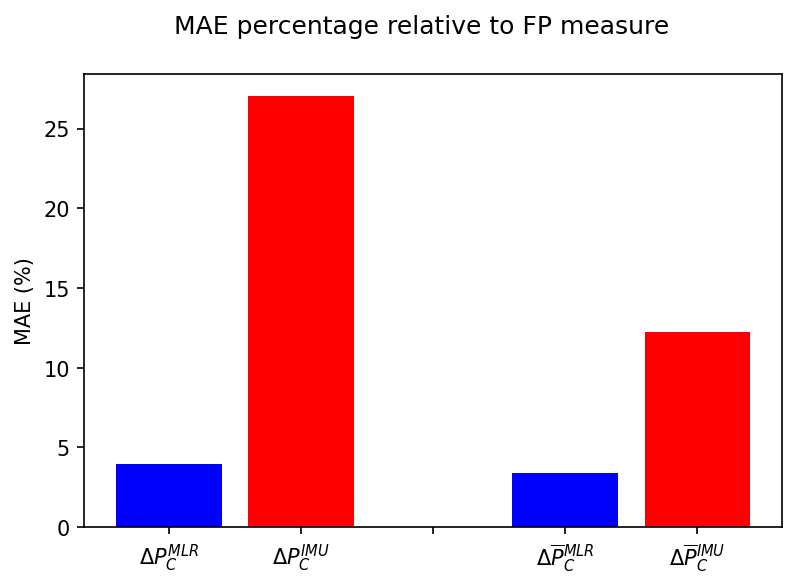

In [6]:
## -- Visualize the improvement -- ##
Pc_D_imu = np.round(np.abs(Pc_fp - Pc_imu), 2)
Pc_D_MLR = np.round(np.abs(Pc_fp - Pc_MLR), 2)
MPc_D_imu = np.round(np.abs(MPc_fp - MPc_imu), 2)
MPc_D_MLR = np.round(np.abs(MPc_fp - MPc_MLR), 2)

perc_Pc_D_imu = np.round(np.abs( Pc_D_imu / Pc_fp ) * 100, 2)
perc_Pc_D_MLR = np.round(np.abs( Pc_D_MLR / Pc_fp ) * 100, 2)
perc_MPc_D_imu = np.round(np.abs( MPc_D_imu / Pc_fp ) * 100, 2)
perc_MPc_D_MLR = np.round(np.abs( MPc_D_MLR / Pc_fp ) * 100, 2)

fig = plt.figure
print(perc_Pc_D_imu, perc_Pc_D_MLR, perc_MPc_D_imu, perc_MPc_D_MLR)

x = ('$\Delta P_C^{MLR}$', '$\Delta P_C^{IMU}$', '', '$\Delta \overline{P}_C^{MLR}$', '$\Delta \overline{P}_C^{IMU}$')
height = [perc_Pc_D_MLR, perc_Pc_D_imu, 0.00, perc_MPc_D_MLR, perc_MPc_D_imu]

fig = plt.figure(1)
fig.dpi = 150
plt.ylabel('MAE (%)')
plt.suptitle('MAE percentage relative to FP measure')
plt.bar(x, height, color = ['blue', 'red', 'blue', 'blue', 'red'])
